# Marketing Analytics Group Project - Fall'22 - Sales Forecasting
---
### Group M

## Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import statsmodels as sm
import statsmodels.api as sm_api

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

import contextlib
import warnings

import copy 
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

from datetime import date, timedelta
import datetime

from tslearn.clustering import TimeSeriesKMeans
# try:
#   !pip install pystan~=2.14
#   !pip install fbprophet
# except:
#   pass

In [2]:
# filter simple warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
import os
os.getcwd()

'/home/praths/notebooks/MIS-381N/MIS_group_project/MIS_group_project'

## Reading Datasets
---
* reading train, test, oil, stores, transactions and holiday data

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
oil = pd.read_csv('oil.csv')
stores = pd.read_csv('stores.csv')
transactions = pd.read_csv('transactions.csv')
holiday_events = pd.read_csv('holidays_events.csv')

## Data preprocessing
---
* checking datasets that can be used for analysis and modelling
* checking NULL values across all datasets 
* treating NULL values
* Joining train and test datasets with 

In [5]:
train_backup = copy.deepcopy(train)
test_backup = copy.deepcopy(test)

In [6]:
print(train.shape)
train.head(3)

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [7]:
print(test.shape)
test.head(3)

(28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2


In [8]:
# train data is present for 4 years from 2013-2017 and test data is present for 15 days
min(train['date']), max(train['date']), min(test['date']), max(test['date'])

('2013-01-01', '2017-08-15', '2017-08-16', '2017-08-31')

In [9]:
# There are 54 different sotes and 33 product families in the train dataset
train['family'].value_counts().shape, train['store_nbr'].value_counts().shape

((33,), (54,))

In [10]:
train['family'].unique(), train['store_nbr'].unique()

(array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
        'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
        'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
        'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
        'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
        'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
        'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
        'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
        'SEAFOOD'], dtype=object),
 array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
         7,  8,  9]))

**Adding holiday and oil price information to the train data**

In [11]:
# adding holiday flag if there is a holiday present on that day
holiday_events['holiday_present'] = 1
holiday_events.rename(columns={'type' : 'holiday_type'}, inplace=True)
holiday_events_df = holiday_events[['date','holiday_present','holiday_type']]

# removing id column as it will not be used in predictions
train_id_dropped = train.drop('id', axis=1)
train_df = pd.merge(train_id_dropped, holiday_events, on='date', how='left')
train_df.loc[train_df['holiday_present'].isna(), 'holiday_type'] = 'not_holiday'
train_df.loc[train_df['holiday_present'].isna(), 'holiday_present'] = 0

In [12]:
# merging oil data with train dataset
oil = oil.fillna(method='bfill')
train_holiday_oil_df = pd.merge(train_df, oil, on='date', how='left')
train_holiday_oil_df['dcoilwtico'].fillna(method='bfill', inplace=True)

In [13]:
train_holiday_oil_df.head(5)

,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,holiday_present,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,1.0,93.14
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,1.0,93.14
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,1.0,93.14
3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,1.0,93.14
4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,1.0,93.14


**checking NULL values**

In [14]:
# locale_name, description, transferred holiday etc. are ignored as they are not considered for our analysis
train_holiday_oil_df.isnull().sum()

date                     0
store_nbr                0
family                   0
sales                    0
onpromotion              0
holiday_type             0
locale             2551824
locale_name        2551824
description        2551824
transferred        2551824
holiday_present          0
dcoilwtico               0
dtype: int64

In [15]:
# subset specific columns and ready data for EDA
train_holiday_oil_df = train_holiday_oil_df[['date', 'store_nbr', 'family', 'sales', 'onpromotion', \
                                             'holiday_type', 'holiday_present', 'dcoilwtico']]

train_holiday_oil_df.head(5)

,date,store_nbr,family,sales,onpromotion,holiday_type,holiday_present,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,1.0,93.14
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,1.0,93.14
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,1.0,93.14
3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,1.0,93.14
4,2013-01-01,1,BOOKS,0.0,0,Holiday,1.0,93.14


## Exploratory data analysis
---
* Checking time series trends across stores and product families
* Impact of oil prices on sales
* Impact of promotions and holidays on sales

**Time series for Stores**

<AxesSubplot:xlabel='None,date'>

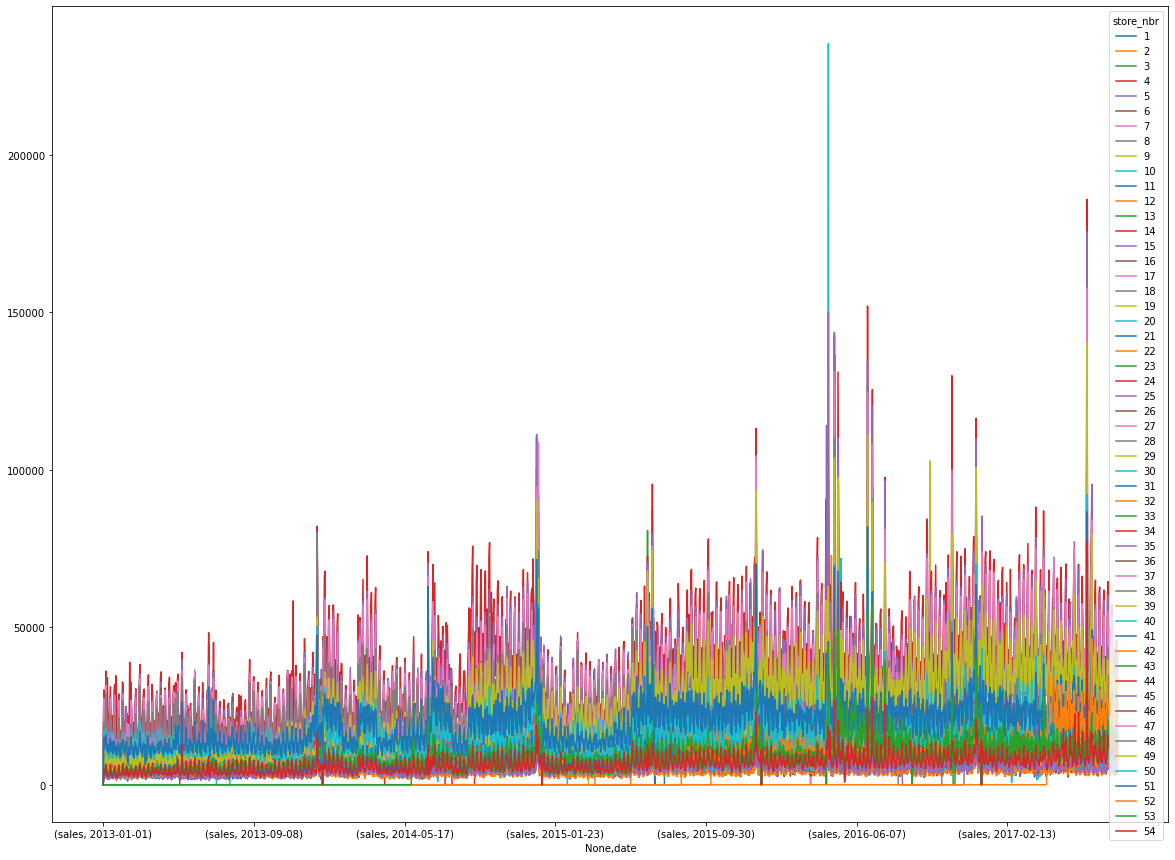

In [16]:
# sales across stores seem to have similar trends at a daily level with occasional spikes
train_holiday_oil_df[['sales', 'store_nbr', 'date']].groupby(['store_nbr','date']).agg({'sales':'sum'})\
.unstack().transpose().plot(figsize=(20,15))

**Checking if certain stores have similar time series shapes using dynamic time warping**

In [17]:
# #aggregating data at store-date level
# stores_ts_sales = train_holiday_oil_df[['sales', 'store_nbr', 'date']].groupby(['store_nbr','date']).agg({'sales':'sum'})\
# .unstack()

In [18]:
# %%time
# ts_clust_fit_stores = TimeSeriesKMeans(n_clusters=3, metric="dtw",
#                          max_iter=10, random_state=0).fit(stores_ts_sales)

In [19]:
# %%time
# predicted_ts_clusters = ts_clust_fit_stores.predict(stores_ts_sales)

In [20]:
# clusters_df_stores = pd.Series(predicted_ts_clusters, index=stores_ts_sales.index, name='cluster')
# cluster_stores_ts = stores_ts_sales.merge(clusters_df_stores.to_frame(), left_index=True, right_index=True)
# cluster_stores_ts['cluster'].value_counts()

In [21]:
# cluster_stores_ts[cluster_stores_ts['cluster'] == 0].transpose().plot(figsize=(20,15))

In [22]:
# cluster_stores_ts[cluster_stores_ts['cluster'] == 1].transpose().plot(figsize=(20,15))

In [23]:
# cluster_stores_ts[cluster_stores_ts['cluster'] == 2].transpose().plot(figsize=(20,15))

**Time series for product families**

In [24]:
# # aggregating data at product-date level
# train_holiday_oil_df[['sales', 'family', 'date']].groupby(['family','date']).agg({'sales':'sum'})\
# .unstack().transpose().plot(figsize=(20,15))

In [25]:
# family_ts_sales = train_holiday_oil_df[['sales', 'family', 'date']].groupby(['family','date']).agg({'sales':'sum'})\
# .unstack()

In [26]:
# %%time
# ts_clust_fit_family = TimeSeriesKMeans(n_clusters=3, metric="dtw",
#                          max_iter=10, random_state=0).fit(family_ts_sales)

In [27]:
# %%time
# predicted_ts_clusters = ts_clust_fit_family.predict(family_ts_sales)

In [28]:
# clusters_df_family = pd.Series(predicted_ts_clusters, index=family_ts_sales.index, name='cluster')
# cluster_family_ts = family_ts_sales.merge(clusters_df_family.to_frame(), left_index=True, right_index=True)

In [29]:
# cluster_family_ts['cluster'].value_counts()

In [30]:
# cluster_family_ts[cluster_family_ts['cluster'] == 0].transpose().plot(figsize=(20,15))

In [31]:
# cluster_family_ts[cluster_family_ts['cluster'] == 1].transpose().plot(figsize=(20,15))

In [32]:
# cluster_family_ts[cluster_family_ts['cluster'] == 2].transpose().plot(figsize=(20,15))

**Checking impact of external factors (oil, promotions and holidays) on overall sales**


In [33]:
train_holiday_oil_grouped_by_date  = train_holiday_oil_df.groupby('date')\
[['sales','dcoilwtico','holiday_present','onpromotion']]\
.agg({'sales':'sum', 'dcoilwtico':'mean','onpromotion':'mean','holiday_present':'max'})

<AxesSubplot:>

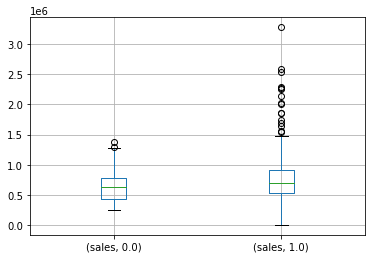

In [34]:
train_holiday_oil_grouped_by_date[['sales', 'holiday_present']].pivot(columns=['holiday_present']).boxplot()

<AxesSubplot:xlabel='sales', ylabel='onpromotion'>

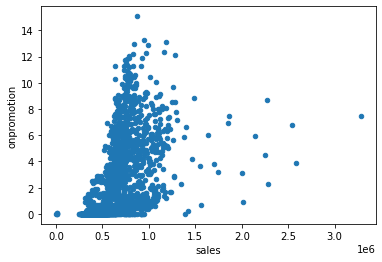

In [35]:
train_holiday_oil_grouped_by_date[['sales', 'onpromotion']].sort_values(by='sales').plot.scatter(x='sales', y='onpromotion')

**Holidays and promotions have impact on sales and they will be considered while building the model**

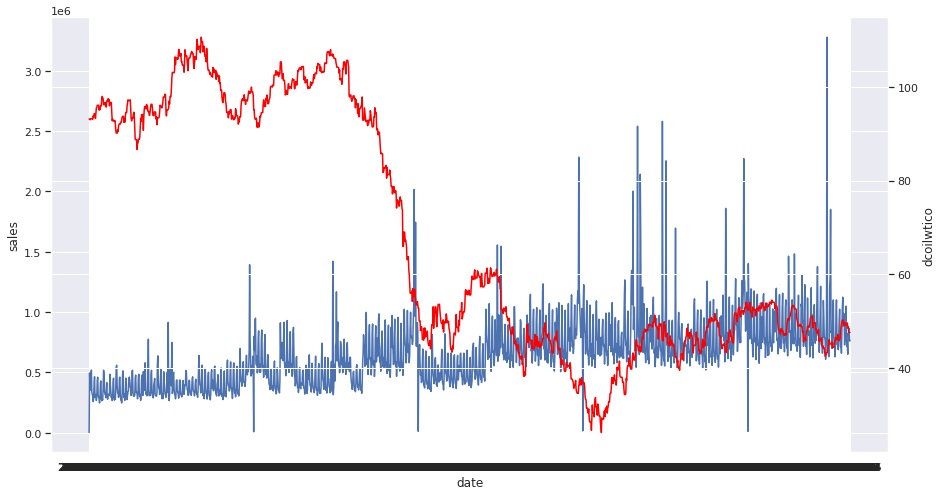

In [36]:
# plotting this takes too much time, skip this cell
sns.set(rc = {'figure.figsize':(15,8)})
fig, ax = plt.subplots()
ax= sns.lineplot(x=train_holiday_oil_grouped_by_date.index, y='sales', data=train_holiday_oil_grouped_by_date)
# adding secondary axis for oil
ax1 = ax.twinx()
ax1 = sns.lineplot(x=train_holiday_oil_grouped_by_date.index, y='dcoilwtico', data=train_holiday_oil_grouped_by_date, color='red', ci=None)
# strong negative correlation between sales and oil prices

In [41]:
train_holiday_oil_grouped_by_date[['dcoilwtico']].values

array([[93.14],
       [93.14],
       [92.97],
       ...,
       [47.59],
       [47.59],
       [47.57]])

In [57]:
Y[:,0]

array([  2511.618999 , 496092.417944 , 361461.231124 , ...,
       865639.677471 , 760922.4060808, 762661.935939 ])

In [55]:
X .shape, Y.shape

((1684, 2), (1684, 1))

In [62]:
# external_merged = residual.to_frame().merge(train, left_index=True, right_index=True)

# regressing the holiday variable against sales to calculate betas for effects
x = np.array(train_holiday_oil_grouped_by_date[['dcoilwtico']].values)
X = sm_api.add_constant(x)
y = np.array(train_holiday_oil_grouped_by_date[['sales']].values)[:,0]
ols = sm.regression.linear_model.OLS(y, X)
ols_fit = ols.fit()
# beta_val = ols_fit.params[0][1]

In [ ]:
x = np.asarray(list21)
y = np.asarray(list23)
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit()
y_pred = results.predict(X)

In [63]:
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     754.9
Date:                Tue, 08 Nov 2022   Prob (F-statistic):          1.36e-137
Time:                        11:22:22   Log-Likelihood:                -23177.
No. Observations:                1684   AIC:                         4.636e+04
Df Residuals:                    1682   BIC:                         4.637e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.057e+06   1.58e+04     66.894      0.000    1.03e+06    1.09e+06
x1         -5984.1028    217.801    -27.475      0.000   -6411.291   -5556.914
==============================================================================
Omnibus:                     1074.015   Durbin-Watson:                   1.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22885.630
Skew:                           2.619   Prob(JB):                         0.00
Kurtosis:                      20.284   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**There is a strong negative correlation between sales and oil prices**

### Decomposition and running the forecast at overall level
---
* Checking if simple seasonal decompostion can give good results at overall level

In [20]:
# making a 80:20 split for train and validation
train_validation_cutoff = int(train_holiday_oil_grouped_by_date.shape[0]*0.8)
train_holiday_oil_grouped_by_date.index = train_holiday_oil_grouped_by_date.index.map(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d'))
train = train_holiday_oil_grouped_by_date.iloc[:train_validation_cutoff]
validation = train_holiday_oil_grouped_by_date.iloc[train_validation_cutoff:]

In [21]:
# converting dataframe to time series and decomposing to trend, seasonal and residue
train_ts = pd.Series(train['sales'], index=train.index)
tsdecomposed = seasonal_decompose(train_ts, model='additive', period=365)

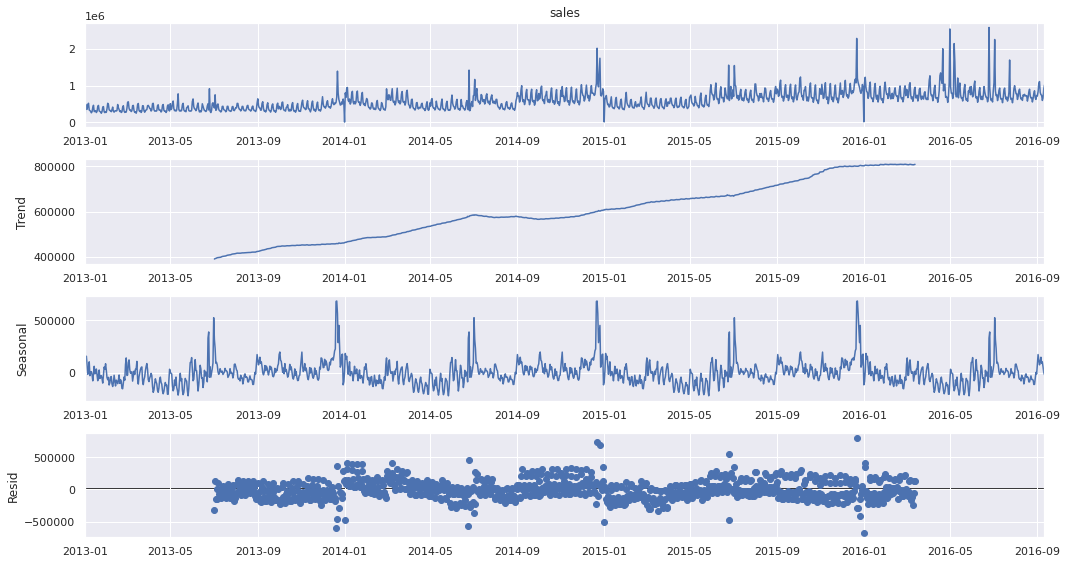

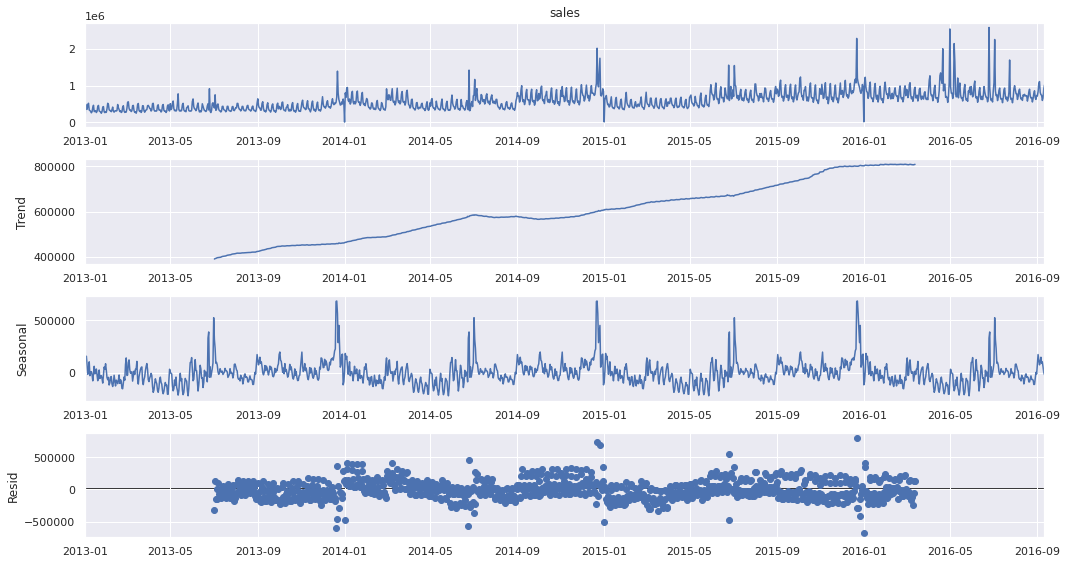

In [22]:
tsdecomposed.plot()

## direct exponential smoothening

In [23]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [24]:
exp_smt = SimpleExpSmoothing(train['sales']).fit(smoothing_level=0.2,optimized=False)
exp_smt_yhat  = exp_smt.forecast(len(validation))
yhat_exp_smoothening = pd.Series(exp_smt_yhat.values, index=validation.index)

In [25]:
mape_cal = validation.merge(pd.Series(yhat_exp_smoothening , name='sales'), how='inner', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))

CPU times: user 142 ms, sys: 72.7 ms, total: 214 ms
Wall time: 116 ms


<AxesSubplot:xlabel='date', ylabel='sales'>

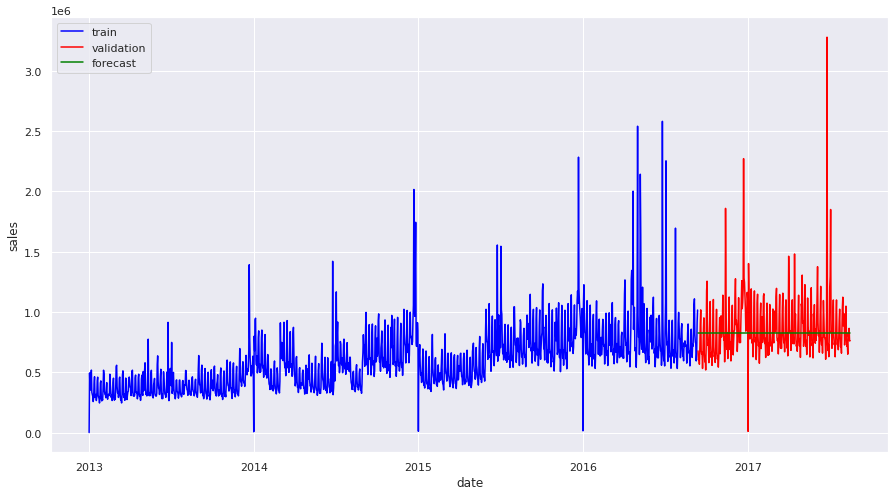

In [26]:
%%time
sns.set(rc = {'figure.figsize':(15,8)})
ax4 = plt.subplots()
sns.lineplot(y=train['sales'], x=train.index, color='blue', label='train')
sns.lineplot(y=mape_cal['sales_actual'], x=mape_cal['sales_actual'].index, color='red', label='validation')
sns.lineplot(y=mape_cal['sales_forecast'], x=mape_cal['sales_forecast'].index, color='green', label = 'forecast')

In [27]:
mape_exp_smoothening = mean_absolute_percentage_error(mape_cal['sales_actual'], mape_cal['sales_forecast']) # mae has reduced
mape_exp_smoothening

0.37043558853893027

## rolling exponential smoothening

In [28]:
exp_smt = SimpleExpSmoothing(train['sales']).fit(smoothing_level=0.2,optimized=False)
exp_smt_yhat  = exp_smt.forecast(len(validation))
yhat_exp_smoothening = pd.Series(exp_smt_yhat.values, index=validation.index)

In [40]:
# Direct holts
predictions = list()
validation_hist = validation.reset_index().iloc[:,1:]
history = [x for x in train['sales'].dropna()]
yhat_total = list()
for t in range(len(validation_hist)):
    exp_smt = SimpleExpSmoothing(train['sales']).fit(smoothing_level=0.2,optimized=False)
#     model = sm.tsa.holtwinters.ExponentialSmoothing(history, trend='add',seasonal='add',seasonal_periods=365)
#     model_fit = model.fit()
    output = exp_smt.forecast()
#     print(output)
    yhat = output.values[0]
#     print(validation_hist['sales'])
    predictions.append(yhat)
    obs = validation_hist['sales'][t]
    history.append(obs)
#     yhat_total.append(yhat)
#     print('predicted=%f, expected=%f' % (yhat, obs))

In [42]:
# predictions

In [43]:
yhat_rolling_forecast = pd.Series(predictions, index=validation.index)

In [44]:
mape_rolling_cal = validation.merge(pd.Series(yhat_rolling_forecast , name='sales'), how='inner', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))

In [45]:
mape_rolling = mean_absolute_percentage_error(mape_rolling_cal['sales_actual'], mape_rolling_cal['sales_forecast']) # mae has reduced
mape_rolling

0.37043558853893027

CPU times: user 139 ms, sys: 100 ms, total: 240 ms
Wall time: 123 ms


<AxesSubplot:xlabel='date', ylabel='sales'>

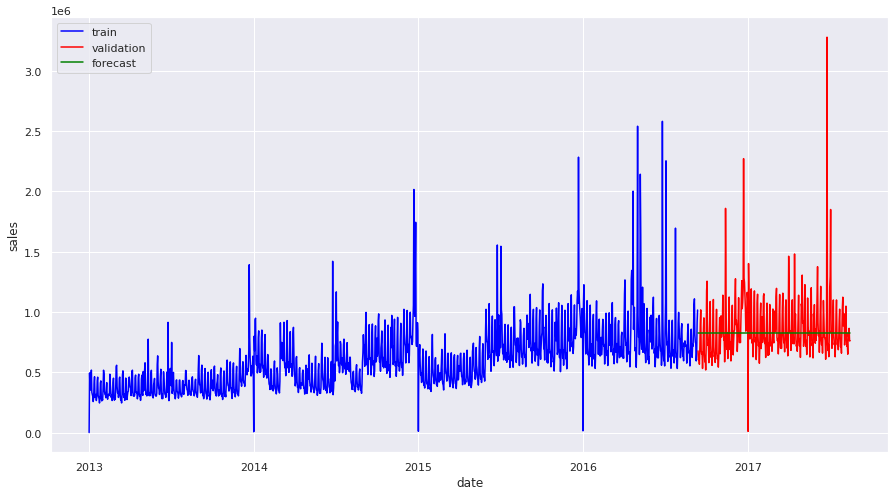

In [47]:
%%time
sns.set(rc = {'figure.figsize':(15,8)})
ax4 = plt.subplots()
sns.lineplot(y=train['sales'], x=train.index, color='blue', label='train')
sns.lineplot(y=mape_rolling_cal['sales_actual'], x=mape_rolling_cal['sales_actual'].index, color='red', label='validation')
sns.lineplot(y=mape_rolling_cal['sales_forecast'], x=mape_rolling_cal['sales_forecast'].index, color='green', label = 'forecast')

## Holts (Double exponential smoothening)

In [48]:
# ht = sm.tsa.api.Holt(train['sales'], smoothing_level=0.1, smoothing_slope=0.3)


ht = Holt(train['sales']).fit(smoothing_level=0.1, smoothing_slope=0.03)
ht_yhat  = ht.forecast(len(validation))
yhat_ht_forecast = pd.Series(ht_yhat.values, index=validation.index)

In [49]:
mape_cal = validation.merge(pd.Series(yhat_ht_forecast , name='sales'), how='inner', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))

CPU times: user 110 ms, sys: 97.8 ms, total: 207 ms
Wall time: 113 ms


<AxesSubplot:xlabel='date', ylabel='sales'>

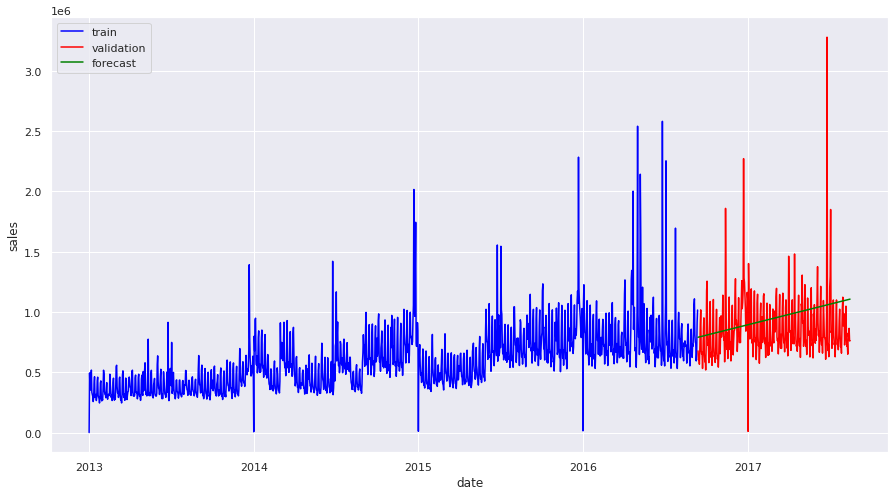

In [50]:
%%time
sns.set(rc = {'figure.figsize':(15,8)})
ax4 = plt.subplots()
sns.lineplot(y=train['sales'], x=train.index, color='blue', label='train')
sns.lineplot(y=mape_cal['sales_actual'], x=mape_cal['sales_actual'].index, color='red', label='validation')
sns.lineplot(y=mape_cal['sales_forecast'], x=mape_cal['sales_forecast'].index, color='green', label = 'forecast')

In [51]:
mape_ht = mean_absolute_percentage_error(mape_cal['sales_actual'], mape_cal['sales_forecast']) # mae has reduced
mape_ht

0.461447075794847

## Holts (Double exponential smoothening) - rolling

In [52]:
predictions = list()
validation_hist = validation.reset_index().iloc[:,1:]
history = [x for x in train['sales'].dropna()]
yhat_total = list()
for t in range(len(validation_hist)):
    model = Holt(train['sales'])
    model_fit = model.fit(smoothing_level=0.1, smoothing_slope=0.03)
    output = model_fit.forecast()
    yhat = output.values[0]
    predictions.append(yhat)
    obs = validation_hist['sales'][t]
    history.append(obs)

In [53]:
yhat_rolling_forecast = pd.Series(predictions, index=validation.index)

In [54]:
mape_rolling_cal = validation.merge(pd.Series(yhat_rolling_forecast , name='sales'), how='inner', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))

In [55]:
mape_rolling = mean_absolute_percentage_error(mape_rolling_cal['sales_actual'], mape_rolling_cal['sales_forecast']) # mape has reduced
mape_rolling

0.3516549307566173

CPU times: user 107 ms, sys: 97.8 ms, total: 205 ms
Wall time: 112 ms


<AxesSubplot:xlabel='date', ylabel='sales'>

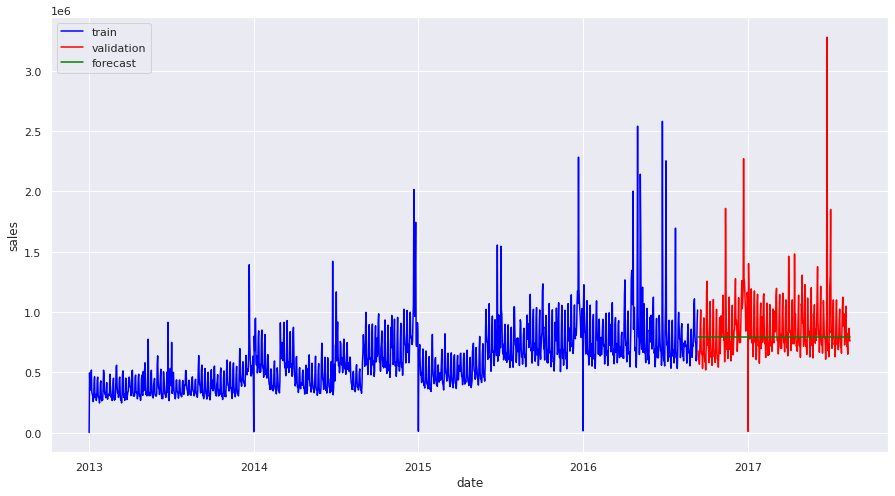

In [56]:
%%time
sns.set(rc = {'figure.figsize':(15,8)})
ax4 = plt.subplots()
sns.lineplot(y=train['sales'], x=train.index, color='blue', label='train')
sns.lineplot(y=mape_rolling_cal['sales_actual'], x=mape_rolling_cal['sales_actual'].index, color='red', label='validation')
sns.lineplot(y=mape_rolling_cal['sales_forecast'], x=mape_rolling_cal['sales_forecast'].index, color='green', label = 'forecast')

## Direct holts winter (additive trend and seasonality)

In [57]:
hwt = sm.tsa.holtwinters.ExponentialSmoothing(train['sales'], trend='add',seasonal='add',seasonal_periods=365)
hwt_fitted = hwt.fit()
yhat = hwt_fitted.forecast(len(validation))
yhat_forecast = pd.Series(yhat.values, index=validation.index)

In [58]:
mape_cal = validation.merge(pd.Series(yhat_forecast , name='sales'), how='inner', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))

CPU times: user 151 ms, sys: 62.3 ms, total: 213 ms
Wall time: 115 ms


<AxesSubplot:xlabel='date', ylabel='sales'>

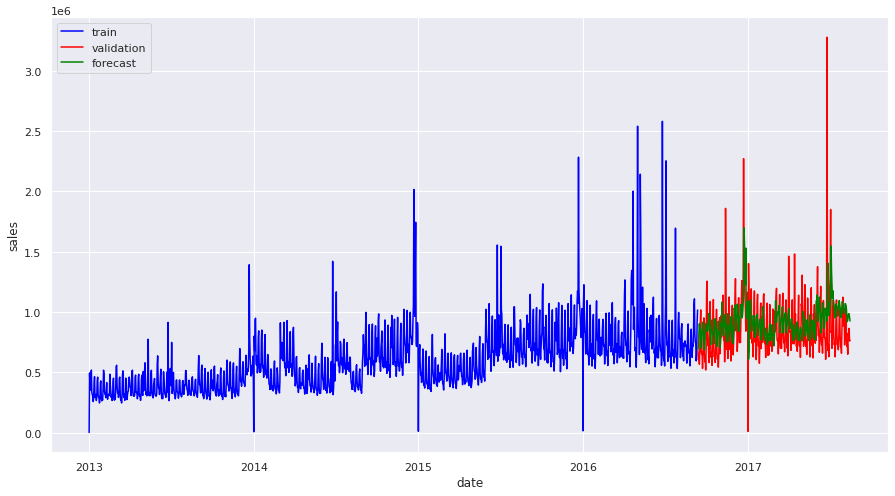

In [59]:
%%time
sns.set(rc = {'figure.figsize':(15,8)})
ax4 = plt.subplots()
sns.lineplot(y=train['sales'], x=train.index, color='blue', label='train')
sns.lineplot(y=mape_cal['sales_actual'], x=mape_cal['sales_actual'].index, color='red', label='validation')
sns.lineplot(y=mape_cal['sales_forecast'], x=mape_cal['sales_forecast'].index, color='green', label = 'forecast')

In [60]:
mape_exp_smoothening = mean_absolute_percentage_error(mape_cal['sales_actual'], mape_cal['sales_forecast']) # mae has reduced
mape_exp_smoothening

0.4845909863002748

# rolling holts winter

In [61]:
# predictions = list()

# model = sm.tsa.holtwinters.ExponentialSmoothing(history) 
# model_fit = model.fit()
# yhat = model_fit.forecast(len(validation))


# residue_adjusted_series = pd.Series(yhat[0], index=validation.index)
    
# predictions = residue_adjusted_series - np.mean(residue_adjusted_series)

In [62]:
predictions = list()
validation_hist = validation.reset_index().iloc[:,1:]
history = [x for x in train['sales'].dropna()]
yhat_total = list()
for t in range(len(validation_hist)):
    model = sm.tsa.holtwinters.ExponentialSmoothing(history, trend='add',seasonal='add',seasonal_periods=365)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
#     print(validation_hist['sales'])
    predictions.append(yhat)
    obs = validation_hist['sales'][t]
    history.append(obs)
#     yhat_total.append(yhat)
#     print('predicted=%f, expected=%f' % (yhat, obs))

In [63]:
yhat_rolling_forecast = pd.Series(predictions, index=validation.index)

In [64]:
mape_rolling_cal = validation.merge(pd.Series(yhat_rolling_forecast , name='sales'), how='inner', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))

In [65]:
mape_rolling = mean_absolute_percentage_error(mape_rolling_cal['sales_actual'], mape_rolling_cal['sales_forecast']) # mae has reduced
mape_rolling

0.45996054869963754

CPU times: user 172 ms, sys: 39.7 ms, total: 211 ms
Wall time: 111 ms


<AxesSubplot:xlabel='date', ylabel='sales'>

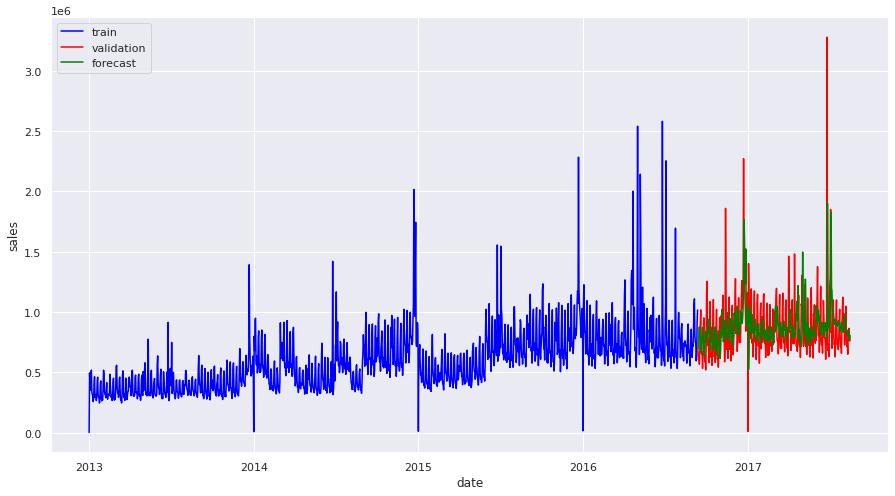

In [66]:
%%time
sns.set(rc = {'figure.figsize':(15,8)})
ax4 = plt.subplots()
sns.lineplot(y=train['sales'], x=train.index, color='blue', label='train')
sns.lineplot(y=mape_rolling_cal['sales_actual'], x=mape_rolling_cal['sales_actual'].index, color='red', label='validation')
sns.lineplot(y=mape_rolling_cal['sales_forecast'], x=mape_rolling_cal['sales_forecast'].index, color='green', label = 'forecast')

**Decomposing trend, seasonal and irregular component**

In [67]:
trend = tsdecomposed.trend
seasonality = tsdecomposed.seasonal
trend_filled_forward = trend.ffill().bfill()

residual = train_ts - trend_filled_forward - seasonality

<AxesSubplot:xlabel='date'>

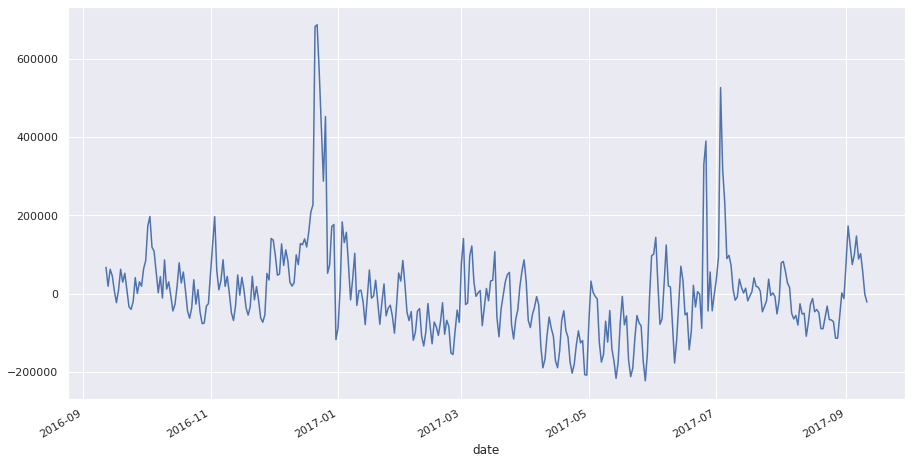

In [68]:
# forecasting seasonality
# get seasonality factors for past 1 year and propogate the seasonality
seasonality_forward = seasonality[seasonality.index > max(train.index) - timedelta(365)]
# create timestamp index from past 1 year to date
seasonality_forward.index = seasonality_forward.index + timedelta(365)
seasonality_forward.plot()

<AxesSubplot:xlabel='date'>

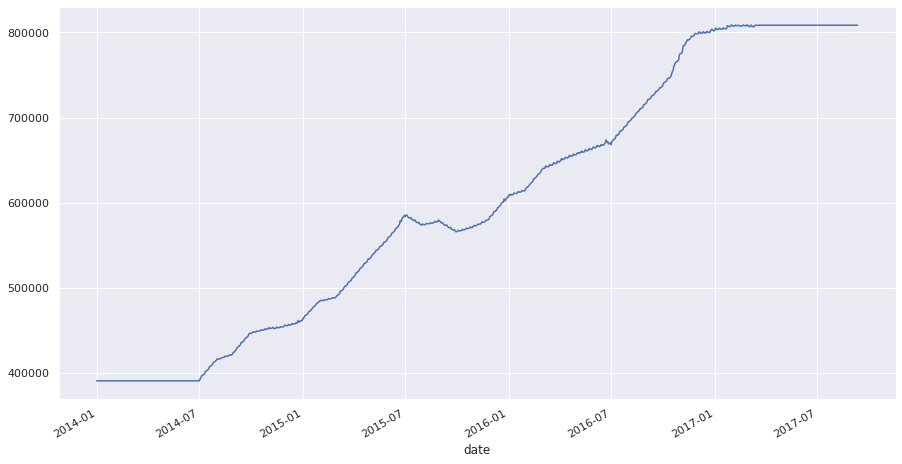

In [69]:
# forecasting trend
# propogate the trend (this is calculated using centered mean - so initial and end values are absent)
trend_filled_forward = trend.ffill().bfill()
# create timestamp index from past 1 year to date
trend_filled_forward.index = trend_filled_forward.index + timedelta(365)
trend_filled_forward.plot()

<AxesSubplot:xlabel='date'>

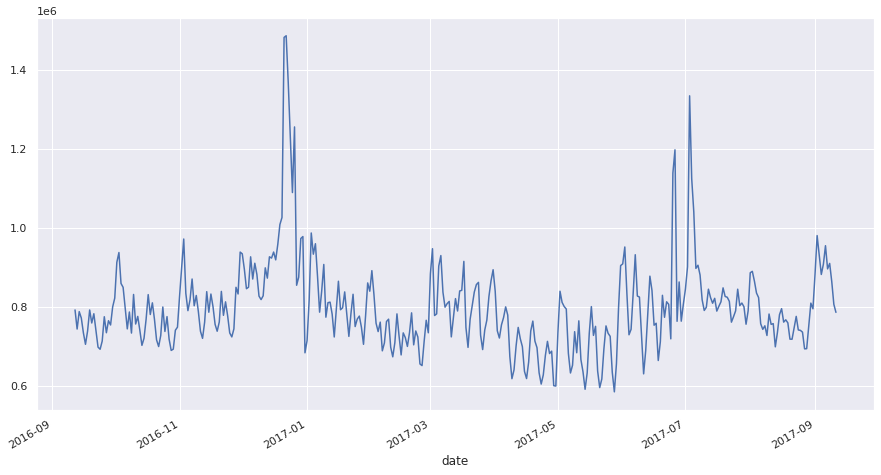

In [70]:
# add propogated trend and forecast
forecast = seasonality_forward + trend_filled_forward
forecast.plot()

In [71]:
mape_cal = validation.merge(pd.Series(forecast , name='sales'), how='inner', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))

In [73]:
# mae_cal2 = validation.merge(pd.Series(forecast1.dropna(), name='sales'), how='inner', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))
mape1 = mean_absolute_percentage_error(mape_cal['sales_actual'], mape_cal['sales_forecast']) # mae has reduced
mape1

0.35093242207912434

CPU times: user 127 ms, sys: 70.7 ms, total: 198 ms
Wall time: 108 ms


<AxesSubplot:xlabel='date', ylabel='sales'>

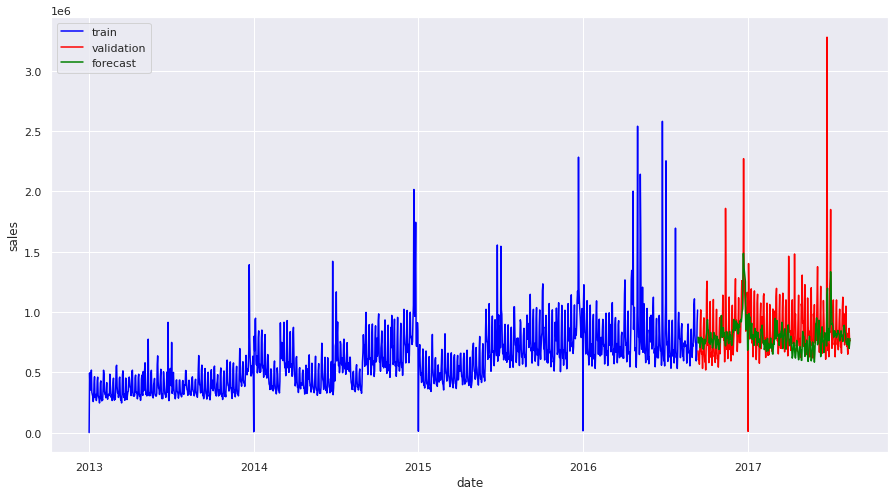

In [75]:
%%time
sns.set(rc = {'figure.figsize':(15,8)})
ax4 = plt.subplots()
sns.lineplot(y=train['sales'], x=train.index, color='blue', label='train')
sns.lineplot(y=mape_cal['sales_actual'], x=mape_cal['sales_actual'].index, color='red', label='validation')
sns.lineplot(y=mape_cal['sales_forecast'], x=mape_cal['sales_forecast'].index, color='green', label = 'forecast')

**This looks like a decent forecast, it can be improved by including the residual/irregular component**

In [76]:
external_merged = residual.to_frame().merge(train, left_index=True, right_index=True)

# regressing the holiday variable against sales to calculate betas for effects
X = np.array(external_merged[['holiday_present', 'onpromotion']])
X = sm_api.add_constant(X)
Y = np.array(external_merged[0])
ols = sm.regression.linear_model.OLS(X, Y)
ols_fit = ols.fit()
beta_val = ols_fit.params[0][1]

In [77]:
# scaling residue based on the holiday variables and removing its effect
residual = external_merged.apply(lambda x: x[0] - x[0]*beta_val  \
                                 if((x['holiday_present'] == 1) or (x['onpromotion'] == 1)) else x[0] ,axis=1)

In [78]:
#ARIMA 1,1,2 model for residue as that gives the better results
history = [x for x in residual.dropna()]
predictions = list()

model = sm.tsa.holtwinters.ExponentialSmoothing(history) 
model_fit = model.fit()
yhat = model_fit.forecast(len(validation))


residue_adjusted_series = pd.Series(yhat[0], index=validation.index)
    
predictions = residue_adjusted_series - np.mean(residue_adjusted_series)

In [79]:
sm.tsa.stattools.adfuller(residual)

(-4.938020220985111,
 2.9394228458066464e-05,
 23,
 1323,
 {'1%': -3.4353024060562674,
  '5%': -2.863727092349239,
  '10%': -2.5679344166325304},
 35022.21112852694)

In [80]:
sales_pred_series = pd.Series(np.array(predictions).ravel(), name='sales_prediction', index=validation.index)
external_merged_post = sales_pred_series.to_frame().merge(validation, left_index=True, right_index=True)

In [81]:
# scaling residue based on the holiday variables and adding back its effect
predictions_corrected = external_merged_post.apply(lambda x: x['sales_prediction'] + x['sales_prediction'] * beta_val \
                                                   if((x['holiday_present'] == 1) or (x['onpromotion'] == 1)) else x['sales_prediction'] ,axis=1)

In [82]:
# adding seasonality, trend and adjusted residue to get the forecast
forecast1 = seasonality_forward + trend_filled_forward + pd.Series(np.array(predictions_corrected).ravel(), index=validation.index)

In [83]:
mae_cal2 = validation.merge(pd.Series(forecast1.dropna(), name='sales'), how='inner', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))
mape2 = mean_absolute_percentage_error(mae_cal2['sales_actual'], mae_cal2['sales_forecast']) # mae has reduced
mape2

0.35093242207912423

In [84]:
mape1 - mape2

1.1102230246251565e-16

In [142]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)4
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Anything below this is not used for marketing

# Spark execution for across stores and products

In [55]:
# https://www.pauldesalvo.com/how-to-install-spark-on-google-colab/

# !sudo apt update
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz
# !tar xf /content/spark-3.0.3-bin-hadoop3.2.tgz
# !pip install -q findspark
# !pip install pyspark

# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

# !pip3 install pyarrow

import findspark
findspark.init()
findspark.find()

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

from pyspark.sql.functions import col, struct, next_day, date_sub, collect_list, array, lit, explode, min, max, first, last
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType, sum, max, col, concat, lit
import sys
import os
from fbprophet import Prophet

import statsmodels.tsa.api as sm
import numpy as np
import pandas as pd
from pandas.core.indexes.datetimes import date_range

Importing plotly failed. Interactive plots will not work.


In [56]:
spark = SparkSession.builder.appName("sales_forecasting_psavale").master("local[*]").getOrCreate()
sc = spark.sparkContext
sc.setSystemProperty("spark.dynamicAllocation.enabled", "true")
sc.setSystemProperty('spark.shuffle.service.enabled', "true")
sc.setSystemProperty("spark.speculation", "true")
sc.setSystemProperty("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
sc.setSystemProperty("spark.driver.memory", "2G")
sc.setSystemProperty("spark.executor.memory", "8G")
sc.setSystemProperty("spark.executor.cores", "2")
sc.setSystemProperty("spark.executor.instances", "20")
sc.setSystemProperty("spark.sql.shuffle.partitions", "400")

/home/praths/anaconda3/envs/py36_gpu/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [57]:
spark

In [58]:
spark.sparkContext.getConf().get("spark.serializer")

'org.apache.spark.serializer.KryoSerializer'

### Train test stratified split
---
* This is required because we want equal division of stores and products across test ant train

In [59]:
family=list(set(train_holiday_oil_df['family']))
store_nbr=list(set(train_holiday_oil_df['store_nbr']))

In [60]:
train_validation_df = train_holiday_oil_df[['date', 'store_nbr', 'family','sales', 'onpromotion', 'holiday_present']]

In [61]:
# 80:20 stratified split is defined here
def train_test_split(data):
    size=int(len(data)*0.8)
    x_train =data.drop(columns=['sales']).iloc[0:size] 
    x_test = data.drop(columns=['sales']).iloc[size:]
    y_train=data['sales'].iloc[0:size] 
    y_test=data['sales'].iloc[size:] 
    return x_train, x_test,y_train,y_test

In [62]:
# %%time
# This takes a long time for execution so pick split data from local
try:
    
    X_train= pd.read_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/X_train.pkl")
    X_test= pd.read_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/X_test.pkl")
    Y_train= pd.read_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/Y_train.pkl")
    Y_test= pd.read_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/Y_test.pkl")

except:
  # this takes a long time to compute
  # loop each family and store number split the data into train and test data
    X_train=[]
    X_test=[]
    Y_train=[]
    Y_test=[]
    for i in range(0,len(family)):
        for j in range(0, len(store_nbr)):
            df = train_validation_df[(train_validation_df['family']==family[i]) & (train_validation_df['store_nbr']==store_nbr[j])]
            x_train, x_test,y_train,y_test=train_test_split(df)
            X_train.append(x_train)
            X_test.append(x_test)
            Y_train.append(y_train)
            Y_test.append(y_test)
    X_train=pd.concat(X_train)
    Y_train=pd.DataFrame(pd.concat(Y_train))
    X_test=pd.concat(X_test)
    Y_test=pd.DataFrame(pd.concat(Y_test))

    X_train.to_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/X_train.pkl")
    X_test.to_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/X_test.pkl")
    Y_train.to_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/Y_train.pkl")
    Y_test.to_pickle("/home/praths/notebooks/MIS/group_project/MIS_group_project/Y_test.pkl")

In [63]:
train = pd.concat([X_train, Y_train], axis=1)
test = pd.concat([X_test, Y_test], axis=1)

In [64]:
train_spark = train[['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'holiday_present']]
train_spark['forecast'] = 0.0
train_spark['mae'] = 0.0

In [65]:
test_spark  = test[['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'holiday_present']]
test_spark['forecast'] = 0.0
test_spark['mae'] = 0.0

In [66]:
# define schema for udf operations
schema = StructType([
        StructField('date', StringType(), True),
        StructField('store_nbr', IntegerType(), True),
        StructField('family', StringType(), True),
        StructField('sales', DoubleType(), True),
        StructField('onpromotion', IntegerType(), True),
        StructField('holiday_present', DoubleType(), True),
        StructField('forecast', DoubleType(), True),
        StructField('mae', DoubleType(), True)
    ])

In [67]:
train_spark_df = spark.createDataFrame(train_spark, schema=schema)
train_spark_df = train_spark_df.withColumn("date", F.to_date(col("date"),"yyyy-MM-dd").alias("date"))

In [68]:
test_spark_df = spark.createDataFrame(test_spark, schema=schema)
test_spark_df = test_spark_df.withColumn("date", F.to_date(col("date"),"yyyy-MM-dd").alias("date"))

In [69]:
cutoff = train_spark_df.select(max(col('date'))).collect()[0][0]
df = (train_spark_df.union(test_spark_df)).sort(col('date'))

**Decomposition and extrapolation**

In [70]:
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def fit_decompose_pandas_udf(df):
    def decompose_udf(df,cutoff):
        
        df['date'] = pd.to_datetime(df['date'])
        ts_train = (df.query('date <= @cutoff'))
        ts_test = (df.query('date > @cutoff'))
        
        ts_train.set_index('date',inplace = True)
        time_series_data = ts_train['sales']

        ts_test.set_index('date',inplace = True)
        ts_test_backup = copy.deepcopy(ts_test)
        ts_test = ts_test.drop('sales', axis=1)
        
        
        train_ts = pd.Series(ts_train['sales'], index=ts_train.index)
        tsdecomposed = seasonal_decompose(train_ts, model='additive', period=365)
        
        # decompose ts
        trend = tsdecomposed.trend
        seasonality = tsdecomposed.seasonal
        
        #ffill trend
        trend_filled_forward = trend.ffill().bfill()
        residual = train_ts - trend_filled_forward - seasonality

        # forecasting seasonality
        # get seasonality factors for past 1 year and propogate the seasonality
        seasonality_forward = seasonality[seasonality.index > train_ts.index.max() - timedelta(ts_test.shape[0])]
        
    
        # create timestamp index from past 1 year to date
        seasonality_forward.index = seasonality_forward.index + timedelta(ts_test.shape[0])
        
        # forecasting trend
        # propogate the trend (this is calculated using centered mean - so initial and end values are absent)
        trend_filled_forward = trend.ffill().bfill()
        # create timestamp index from past 1 year to date
        trend_filled_forward.index = trend_filled_forward.index + timedelta(ts_test.shape[0])


        forecast = seasonality_forward + trend_filled_forward
        

        try:
            preds = ts_test_backup.merge(pd.Series(forecast, name='sales'), how='left', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))
            preds = preds.dropna()
            mae = mean_absolute_error(np.array(preds['sales_actual']), np.array(preds['sales_forecast']))
            return pd.DataFrame({'date': preds.index.astype(str), 'store_nbr': preds.store_nbr,\
                                 'family': preds.family, 'sales': preds.sales_actual,\
                                 'onpromotion': preds.onpromotion, 'holiday_present': preds.holiday_present,\
                                 'forecast':preds.sales_forecast, 'mae': mae})
        except:
            return pd.DataFrame({'date': preds.index.astype(str), 'store_nbr': preds.store_nbr,\
                                 'family': preds.family, 'sales': preds.sales_actual,\
                                 'onpromotion': preds.onpromotion, 'holiday_present': preds.holiday_present,\
                                 'forecast':9999, 'mae': 9999})
    return decompose_udf(df, cutoff)

In [71]:
%%time 
# decompose extension
decompose_fit_df = df\
.groupBy(["store_nbr", "family"])\
.apply(fit_decompose_pandas_udf).cache()
forecasted_decompose_fit_df = decompose_fit_df.groupBy(['store_nbr', 'family']).avg("mae")\
.withColumnRenamed("avg(mae)","avg_mae")
forecasted_decompose_fit_df.select(F.mean('avg_mae')).collect()[0][0]

CPU times: user 107 ms, sys: 17 ms, total: 124 ms
Wall time: 21.3 s


139.25674140723902

**decomposition with adjustment for external factors and residue**

In [76]:
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def fit_decompose_arima_pandas_w_residue_udf(df):
    def decompose_arima_w_residue_udf(df,cutoff):
        
        df['date'] = pd.to_datetime(df['date'])
        ts_train = (df.query('date <= @cutoff'))
        ts_test = (df.query('date > @cutoff'))
        
        ts_train.set_index('date',inplace = True)
        time_series_data = ts_train['sales']

        ts_test.set_index('date',inplace = True)
        ts_test_backup = copy.deepcopy(ts_test)
        ts_test = ts_test.drop('sales', axis=1)
        
        
        train_ts = pd.Series(ts_train['sales'], index=ts_train.index)
        tsdecomposed = seasonal_decompose(train_ts, model='additive', period=365)
        
        # decompose ts
        trend = tsdecomposed.trend
        seasonality = tsdecomposed.seasonal
        
        #ffill trend
        trend_filled_forward = trend.ffill().bfill()
        residual = train_ts - trend_filled_forward - seasonality

        # forecasting seasonality
        # get seasonality factors for past 1 year and propogate the seasonality
        seasonality_forward = seasonality[seasonality.index > train_ts.index.max() - timedelta(ts_test.shape[0])]
        
    
        # create timestamp index from past 1 year to date
        seasonality_forward.index = seasonality_forward.index + timedelta(ts_test.shape[0])
        
        # forecasting trend
        # propogate the trend (this is calculated using centered mean - so initial and end values are absent)
        trend_filled_forward = trend.ffill().bfill()
        # create timestamp index from past 1 year to date
        trend_filled_forward.index = trend_filled_forward.index + timedelta(ts_test.shape[0])


        # adding seasonality and trend
        forecast = seasonality_forward + trend_filled_forward
        
        external_merged = residual.to_frame().merge(ts_train, left_index=True, right_index=True)
        
        #forecasting residue with ARIMA 000
        # regressing the holiday and promotion variable against sales to calculate betas for effect
        X_ext_factor = np.array(external_merged[['holiday_present', 'onpromotion']])
        X_ext_factor = sm_api.add_constant(X_ext_factor)
        Y_ext_factor = np.array(external_merged[0])
        ols_ext_factor = sm_api.regression.linear_model.OLS(X_ext_factor, Y_ext_factor)
        ols_ext_factor_fit = ols_ext_factor.fit()
        beta_ext_factor = ols_ext_factor_fit.params[0][1]
        

        #remove effect of external factors 
        residual = external_merged.apply(lambda x: x[0] - x[0]*beta_ext_factor \
                                         if ((x['holiday_present'] == 1) or (x['onpromotion'] == 1)) else x[0], axis=1)

        history = [x for x in residual.dropna()]

        try:
            model = sm_api.tsa.ARIMA(history, order=(0,0,0))
            model_fit = model.fit()
            yhat = model_fit.forecast(len(ts_test))


            residue_adjusted_series = pd.Series(yhat[0], index=ts_test.index)
            residue_adjusted_series = residue_adjusted_series - np.mean(residue_adjusted_series)

            #add effect of external factors
            external_merged_post = residue_adjusted_series.to_frame(name='sales_prediction').merge(ts_test, left_index=True, right_index=True)


            predictions_corrected = external_merged_post.apply(lambda x: x['sales_prediction'] + \
                                    x['sales_prediction']*beta_ext_factor \
                                         if ((x['holiday_present'] == 1) or (x['onpromotion'] == 1))\
                                                               else x['sales_prediction'], axis=1)

            forecast1 = forecast + predictions_corrected


            preds = ts_test_backup.merge(pd.Series(forecast1, name='sales'), how='left', left_index=True, right_index=True, suffixes=('_actual', '_forecast'))
            preds = preds.dropna()
            mae = mean_absolute_error(np.array(preds['sales_actual']), np.array(preds['sales_forecast']))
            return pd.DataFrame({'date': preds.index.astype(str), 'store_nbr': preds.store_nbr,\
                                 'family': preds.family, 'sales': preds.sales_actual,\
                                 'onpromotion': preds.onpromotion, 'holiday_present': preds.holiday_present,\
                                 'forecast':preds.sales_forecast, 'mae': mae})
        except:
            return pd.DataFrame({'date': ts_test_backup.index.astype(str), 'store_nbr': ts_test_backup.store_nbr,\
                                 'family': ts_test_backup.family, 'sales': ts_test_backup.sales,\
                                 'onpromotion': ts_test_backup.onpromotion, 'holiday_present': ts_test_backup.holiday_present,\
                                 'forecast':9999, 'mae':9999})
    return decompose_arima_w_residue_udf(df, cutoff)
    

In [77]:
%%time
# arima with residue and external regressor adjustment
decompose_arima_fit_w_residue_df = df\
.groupBy(["store_nbr", "family"])\
.apply(fit_decompose_arima_pandas_w_residue_udf).cache()
forecasted_decompose_arima_w_residue_df = decompose_arima_fit_w_residue_df.groupBy(['store_nbr', 'family']).avg("mae")\
.withColumnRenamed("avg(mae)","avg_mae")
forecasted_decompose_arima_w_residue_df.select(F.mean('avg_mae')).collect()[0][0]

CPU times: user 159 ms, sys: 78.8 ms, total: 238 ms
Wall time: 42.4 s


135.52448726673828

**decompose with residue adjustments gives better results compared to only decompose, which is also something that we saw at an overall level**

**Prophet**

In [74]:
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def fit_prophet_auto_arima_udf(df):
    def prophet_auto_arima_udf(df,cutoff):
        
        df['date'] = pd.to_datetime(df['date'])
        ts_train = (df.query('date <= @cutoff')
                   .rename(columns={'date': 'ds', 'sales': 'y'})
                    .sort_values('ds')
                   
                   )
        ts_train = ts_train[['ds', 'y']]
        ts_test = (df.query('date > @cutoff'))
        ts_test_backup = copy.deepcopy(ts_test)
        ts_test = ts_test[['date', 'sales']]
        ts_test = (ts_test.rename(columns={'date': 'ds', 'sales': 'y'})
                  .sort_values('ds')
                   .assign(ds=lambda x: pd.to_datetime(x["ds"]))
                   .drop('y', axis=1))
            
        try:
            m = Prophet(yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False)
            m.fit(ts_train, iter=20)


            ts_hat = (m.predict(ts_test)[["ds", "yhat"]]
                      .assign(ds=lambda x: pd.to_datetime(x["ds"]))
                      ).merge(ts_test, on=["ds"], how="left")

            preds = ts_test_backup.merge(ts_hat, how='inner', left_on='date', right_on='ds', suffixes=('_actual', '_forecast'))
            preds = preds.dropna()

            mae = mean_absolute_error(np.array(preds['sales']), np.array(preds['yhat']))
            return pd.DataFrame({'date': preds.index.astype(str), 'store_nbr': preds.store_nbr,\
                                 'family': preds.family, 'sales': preds.sales,\
                                 'onpromotion': preds.onpromotion, 'holiday_present': preds.holiday_present,\
                                 'forecast':preds['yhat'], 'mae': mae})
        except:
            return pd.DataFrame({'date': ts_test_backup.index.astype(str), 'store_nbr': ts_test_backup.store_nbr,\
                                 'family': ts_test_backup.family, 'sales': ts_test_backup.sales,\
                                 'onpromotion': ts_test_backup.onpromotion, 'holiday_present': ts_test_backup.holiday_present,\
                                 'forecast':9999, 'mae': 9999})
    return prophet_auto_arima_udf(df, cutoff)

In [75]:
%%time
# prophet
prophet_auto_arima_df = df\
.groupBy(["store_nbr", "family"])\
.apply(fit_prophet_auto_arima_udf).cache()
forecasted_prophet_auto_arima_df = prophet_auto_arima_df.groupBy(['store_nbr', 'family']).avg("mae")\
.withColumnRenamed("avg(mae)","avg_mae")
forecasted_prophet_auto_arima_df.select(F.mean('avg_mae')).collect()[0][0]

CPU times: user 169 ms, sys: 47.1 ms, total: 216 ms
Wall time: 6min 20s


148.4759609038448